# Imports

In [1]:
!pip install medmnist seaborn ncps scipy pillow Cmake nes-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5

In [2]:
import os
import imageio
import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import cv2
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import keras.layers
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras import optimizers
from keras.layers import Dropout
from keras.applications import mobilenet
from keras.applications import resnet50


import random as rn
rn.seed(30)
np.random.seed(30)
tf.random.set_seed

from ncps import wirings
from ncps.wirings import AutoNCP
from ncps.tf import LTC

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

from sklearn.metrics import accuracy_score

# Plot accuracy score and loss from training history



In [4]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['sparse_categorical_accuracy'])
    axes[1].plot(history.history['val_sparse_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_sparse_categorical_accuracy'])


# First model: simle CNN blocks + LSTM

In [ ]:
class CNN_LSTM():

    def init(self):
        self.data_flag = 'nodulemnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 128
        self.num_epochs = 20
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)


    def train_generator(self):
        while True:
            self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
            for batch_data, batch_labels in self.train_loader:
                yield np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1]) , batch_labels.numpy()

    def val_generator(self):
        while True:
            self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
            for batch_data, batch_labels in self.val_loader:
                yield np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1]), batch_labels.numpy()


    def train_model(self, model, augment_data=False):
        train_generator = self.train_generator()
        val_generator = self.val_generator()

        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00000001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [checkpoint, LR, earlystop]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                                callbacks=self.callbacks_list, validation_data=val_generator,
                                validation_steps=2, class_weight=None, workers=1, initial_epoch=0)
        return history

    def define_model(self,lstm_cells=32,dense_neurons=32,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=2e-5)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
# strange bug: need to restart this cell to get normal score.
cnn_lstm = CNN_LSTM()
cnn_lstm.init()
cnn_lstm_model = cnn_lstm.define_model(lstm_cells=32,dense_neurons=32,dropout=0.1)
cnn_lstm_model.summary()

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, 28, 28, 28, 16)    160       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 28, 28, 28, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 28, 14, 14, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 28, 14

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_lstm.train_model(cnn_lstm_model)

Epoch 1/20
 9/10 [==========================>...] - ETA: 0s - loss: 0.7304 - sparse_categorical_accuracy: 0.4748
Epoch 1: val_loss improved from inf to 0.69191, saving model to model_2024-03-2410_53_37.853432/first model
10/10 [==============================] - 13s 873ms/step - loss: 0.7307 - sparse_categorical_accuracy: 0.4741 - val_loss: 0.6919 - val_sparse_categorical_accuracy: 0.5515 - lr: 2.0000e-05
Epoch 2/20
 9/10 [==========================>...] - ETA: 0s - loss: 0.6881 - sparse_categorical_accuracy: 0.5651
Epoch 2: val_loss improved from 0.69191 to 0.68655, saving model to model_2024-03-2410_53_37.853432/first model
10/10 [==============================] - 8s 897ms/step - loss: 0.6882 - sparse_categorical_accuracy: 0.5648 - val_loss: 0.6865 - val_sparse_categorical_accuracy: 0.6788 - lr: 2.0000e-05
Epoch 3/20
 9/10 [==========================>...] - ETA: 0s - loss: 0.6628 - sparse_categorical_accuracy: 0.6059
Epoch 3: val_loss improved from 0.68655 to 0.68197, saving model to 

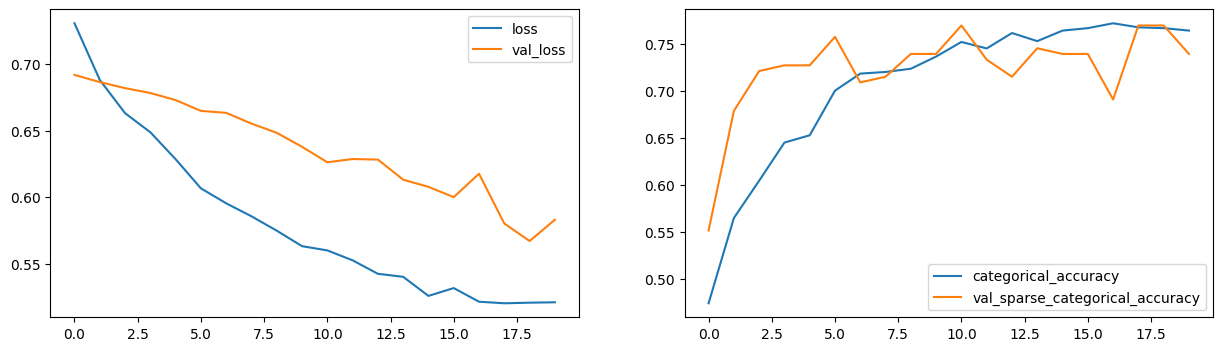

In [ ]:
plot(model)

# Second model: simple CNN blocks + GRU

In [ ]:
class CNN_GRU():

    def init(self):
        self.data_flag = 'nodulemnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 128
        self.num_epochs = 20
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=True)


    def train_generator(self):
        while True:
            self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
            for batch_data, batch_labels in self.train_loader:
                yield np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1]) , batch_labels.numpy()

    def val_generator(self):
        while True:
            self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=True)
            for batch_data, batch_labels in self.val_loader:
                yield np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1]), batch_labels.numpy()


    def train_model(self, model, augment_data=False):
        train_generator = self.train_generator()
        val_generator = self.val_generator()

        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00000001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [checkpoint, LR, earlystop]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                                callbacks=self.callbacks_list, validation_data=val_generator,
                                validation_steps=2, class_weight=None, workers=1, initial_epoch=0)
        return history

    def define_model(self,gru_cells=32,dense_neurons=32,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=2e-5)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model

In [ ]:
# strange bug: need to restart this cell to get normal score.
cnn_gru = CNN_GRU()
cnn_gru.init()
cnn_gru_model = cnn_gru.define_model(gru_cells=32,dense_neurons=32,dropout=0.1)
cnn_gru_model.summary()

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeD  (None, 28, 28, 28, 16)    160       
 istributed)                                                     
                                                                 
 time_distributed_40 (TimeD  (None, 28, 28, 28, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_41 (TimeD  (None, 28, 14, 14, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_42 (TimeD  (None, 28, 14

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_gru.train_model(cnn_gru_model)

Epoch 1/20
 9/10 [==========================>...] - ETA: 0s - loss: 0.8989 - sparse_categorical_accuracy: 0.4210
Epoch 1: val_loss improved from inf to 0.69819, saving model to model_2024-03-2411_05_23.728532/first model
10/10 [==============================] - 13s 971ms/step - loss: 0.8980 - sparse_categorical_accuracy: 0.4223 - val_loss: 0.6982 - val_sparse_categorical_accuracy: 0.3273 - lr: 2.0000e-05
Epoch 2/20
 9/10 [==========================>...] - ETA: 0s - loss: 0.8109 - sparse_categorical_accuracy: 0.4670
Epoch 2: val_loss improved from 0.69819 to 0.69586, saving model to model_2024-03-2411_05_23.728532/first model
10/10 [==============================] - 10s 1s/step - loss: 0.8116 - sparse_categorical_accuracy: 0.4672 - val_loss: 0.6959 - val_sparse_categorical_accuracy: 0.4424 - lr: 2.0000e-05
Epoch 3/20
 9/10 [==========================>...] - ETA: 0s - loss: 0.7585 - sparse_categorical_accuracy: 0.5156
Epoch 3: val_loss improved from 0.69586 to 0.69217, saving model to mo

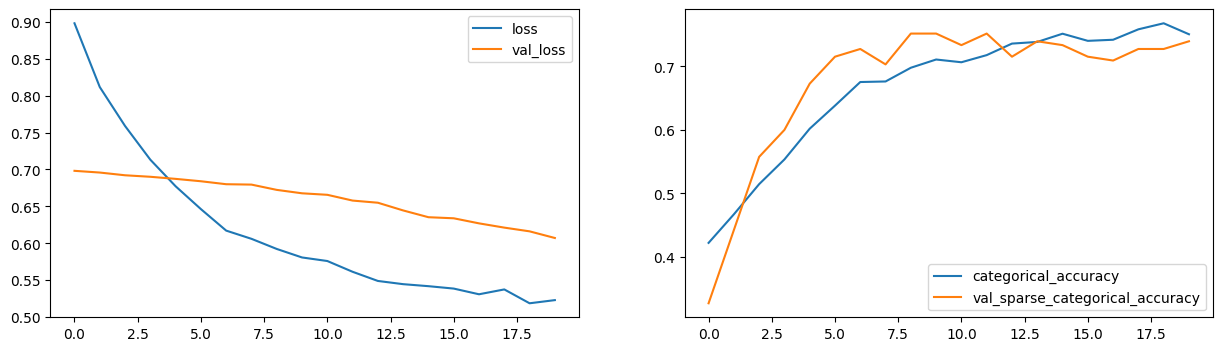

In [ ]:
plot(model)

## Using fit instead of fit_generator

In [ ]:
class CNN_LSTM_fit():

    def init(self):
        self.data_flag = 'nodulemnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 32
        self.num_epochs = 30
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []


    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [checkpoint, LR, earlystop]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self,lstm_cells=32,dense_neurons=32,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=2e-5)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model


In [ ]:
cnn_lstm_2 = CNN_LSTM_fit()
cnn_lstm_2.init()
cnn_lstm_2.create_data()

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz


In [ ]:
cnn_lstm_2_model = cnn_lstm_2.define_model(lstm_cells=32,dense_neurons=32,dropout=0.1)
cnn_lstm_2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_52 (TimeD  (None, 28, 28, 28, 16)    160       
 istributed)                                                     
                                                                 
 time_distributed_53 (TimeD  (None, 28, 28, 28, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_54 (TimeD  (None, 28, 14, 14, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_55 (TimeD  (None, 28, 14, 14, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_56 (TimeD  (None, 28, 14, 14, 32)   

In [ ]:
with tf.device('/device:GPU:0'):
    model = cnn_lstm_2.train_model(cnn_lstm_2_model)

Epoch 1/30
35/37 [===========================>..] - ETA: 0s - loss: 0.7657 - sparse_categorical_accuracy: 0.4393
Epoch 1: val_loss improved from inf to 0.72847, saving model to model_2024-03-2517_35_07.551874/first model
37/37 [==============================] - 13s 253ms/step - loss: 0.7643 - sparse_categorical_accuracy: 0.4413 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.2545 - lr: 2.0000e-05
Epoch 2/30
35/37 [===========================>..] - ETA: 0s - loss: 0.6520 - sparse_categorical_accuracy: 0.6143
Epoch 2: val_loss did not improve from 0.72847
37/37 [==============================] - 1s 30ms/step - loss: 0.6525 - sparse_categorical_accuracy: 0.6149 - val_loss: 0.7646 - val_sparse_categorical_accuracy: 0.2545 - lr: 2.0000e-05
Epoch 3/30
35/37 [===========================>..] - ETA: 0s - loss: 0.5988 - sparse_categorical_accuracy: 0.7000
Epoch 3: val_loss did not improve from 0.72847
37/37 [==============================] - 1s 28ms/step - loss: 0.5974 - sparse_categoric

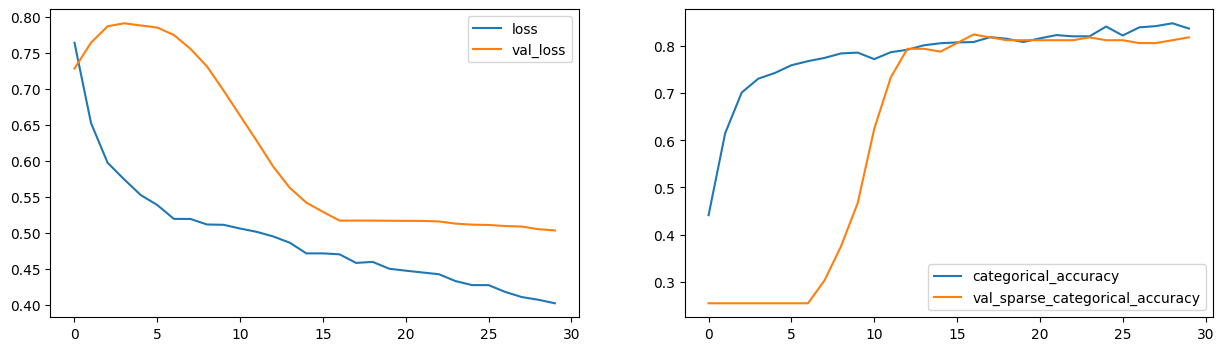

In [ ]:
plot(model)

In [ ]:
cnn_lstm_2_model.evaluate(cnn_lstm_2.x_test, cnn_lstm_2.y_test, batch_size = 32)

10/10 [==============================] - 1s 63ms/step - loss: 0.4434 - sparse_categorical_accuracy: 0.8161


[0.44341951608657837, 0.8161290287971497]

#Score on other datasets

In [16]:
class CNN_LSTM_fit():

    def init(self):
        self.data_flag = 'adrenalmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 32
        self.num_epochs = 30
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []


    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self,lstm_cells=32,dense_neurons=32,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=2e-5)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model


In [17]:
cnn_lstm_2 = CNN_LSTM_fit()
cnn_lstm_2.init()
cnn_lstm_2.create_data()
cnn_lstm_2_model = cnn_lstm_2.define_model(lstm_cells=64,dense_neurons=32,dropout=0.1)
cnn_lstm_2_model.summary()

100%|██████████| 276833/276833 [00:00<00:00, 735238.99it/s]


Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_52 (TimeD  (None, 28, 28, 28, 16)    160       
 istributed)                                                     
                                                                 
 time_distributed_53 (TimeD  (None, 28, 28, 28, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_54 (TimeD  (None, 28, 14, 14, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_55 (TimeD  (None, 28, 14, 14, 32)    4640      
 istributed)                                

In [18]:
with tf.device('/device:GPU:0'):
    model = cnn_lstm_2.train_model(cnn_lstm_2_model)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.5971 - sparse_categorical_accuracy: 0.7054
Epoch 1: val_loss improved from inf to 0.66912, saving model to model_2024-04-2015_34_30.469395/first model
38/38 [==============================] - 14s 258ms/step - loss: 0.5971 - sparse_categorical_accuracy: 0.7054 - val_loss: 0.6691 - val_sparse_categorical_accuracy: 0.7755 - lr: 2.0000e-05
Epoch 2/30
37/38 [============================>.] - ETA: 0s - loss: 0.5239 - sparse_categorical_accuracy: 0.7804
Epoch 2: val_loss improved from 0.66912 to 0.62268, saving model to model_2024-04-2015_34_30.469395/first model
38/38 [==============================] - 9s 234ms/step - loss: 0.5229 - sparse_categorical_accuracy: 0.7811 - val_loss: 0.6227 - val_sparse_categorical_accuracy: 0.7755 - lr: 2.0000e-05
Epoch 3/30
37/38 [============================>.] - ETA: 0s - loss: 0.5225 - sparse_categorical_accuracy: 0.7821
Epoch 3: val_loss improved from 0.62268 to 0.58824, saving model to 

In [19]:
cnn_lstm_2_model.evaluate(cnn_lstm_2.x_test, cnn_lstm_2.y_test, batch_size = 32)

10/10 [==============================] - 0s 31ms/step - loss: 0.4600 - sparse_categorical_accuracy: 0.8020


[0.4599880278110504, 0.8020133972167969]

In [23]:
class CNN_LSTM_fit():

    def init(self):
        self.data_flag = 'vesselmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 32
        self.num_epochs = 30
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []


    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [LR]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self,lstm_cells=32,dense_neurons=32,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=2e-5)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model


In [24]:
cnn_lstm_2 = CNN_LSTM_fit()
cnn_lstm_2.init()
cnn_lstm_2.create_data()
cnn_lstm_2_model = cnn_lstm_2.define_model(lstm_cells=64,dense_neurons=32,dropout=0.1)
cnn_lstm_2_model.summary()

Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_78 (TimeD  (None, 28, 28, 28, 16)    160       
 istributed)                                                     
                                                                 
 time_distributed_79 (TimeD  (None, 28, 28, 28, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_80 (TimeD  (None, 28, 14, 14, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_81 (TimeD  (None, 28, 14

In [25]:
with tf.device('/device:GPU:0'):
    model = cnn_lstm_2.train_model(cnn_lstm_2_model)

Epoch 1/30
42/42 [==============================] - 7s 47ms/step - loss: 0.6003 - sparse_categorical_accuracy: 0.7026 - val_loss: 0.6605 - val_sparse_categorical_accuracy: 0.8848 - lr: 2.0000e-05
Epoch 2/30
42/42 [==============================] - 1s 28ms/step - loss: 0.4118 - sparse_categorical_accuracy: 0.8704 - val_loss: 0.5463 - val_sparse_categorical_accuracy: 0.8848 - lr: 2.0000e-05
Epoch 3/30
42/42 [==============================] - 1s 29ms/step - loss: 0.3730 - sparse_categorical_accuracy: 0.8839 - val_loss: 0.4484 - val_sparse_categorical_accuracy: 0.8848 - lr: 2.0000e-05
Epoch 4/30
42/42 [==============================] - 1s 29ms/step - loss: 0.3585 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.3969 - val_sparse_categorical_accuracy: 0.8848 - lr: 2.0000e-05
Epoch 5/30
42/42 [==============================] - 1s 29ms/step - loss: 0.3531 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.3731 - val_sparse_categorical_accuracy: 0.8848 - lr: 2.0000e-05
Epoch 6/30
42/42 [==

In [26]:
cnn_lstm_2_model.evaluate(cnn_lstm_2.x_test, cnn_lstm_2.y_test, batch_size = 32)

12/12 [==============================] - 0s 35ms/step - loss: 0.3250 - sparse_categorical_accuracy: 0.8848


[0.325027197599411, 0.8848167657852173]

In [27]:
class CNN_LSTM_fit():

    def init(self):
        self.data_flag = 'synapsemnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 32
        self.num_epochs = 30
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []


    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [LR]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self,lstm_cells=32,dense_neurons=32,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=2e-5)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model


In [28]:
cnn_lstm_2 = CNN_LSTM_fit()
cnn_lstm_2.init()
cnn_lstm_2.create_data()
cnn_lstm_2_model = cnn_lstm_2.define_model(lstm_cells=64,dense_neurons=32,dropout=0.1)
cnn_lstm_2_model.summary()

100%|██████████| 38034583/38034583 [00:02<00:00, 16220066.49it/s]


Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_91 (TimeD  (None, 28, 28, 28, 16)    160       
 istributed)                                                     
                                                                 
 time_distributed_92 (TimeD  (None, 28, 28, 28, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_93 (TimeD  (None, 28, 14, 14, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_94 (TimeD  (None, 28, 14, 14, 32)    4640      
 istributed)                                

In [29]:
with tf.device('/device:GPU:0'):
    model = cnn_lstm_2.train_model(cnn_lstm_2_model)

Epoch 1/30
39/39 [==============================] - 14s 118ms/step - loss: 0.6050 - sparse_categorical_accuracy: 0.7081 - val_loss: 0.6867 - val_sparse_categorical_accuracy: 0.7288 - lr: 2.0000e-05
Epoch 2/30
39/39 [==============================] - 2s 51ms/step - loss: 0.5804 - sparse_categorical_accuracy: 0.7268 - val_loss: 0.7260 - val_sparse_categorical_accuracy: 0.2712 - lr: 2.0000e-05
Epoch 3/30
39/39 [==============================] - 1s 38ms/step - loss: 0.5700 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.7638 - val_sparse_categorical_accuracy: 0.2712 - lr: 2.0000e-05
Epoch 4/30
39/39 [==============================] - 1s 32ms/step - loss: 0.5529 - sparse_categorical_accuracy: 0.7301 - val_loss: 0.7806 - val_sparse_categorical_accuracy: 0.2712 - lr: 2.0000e-05
Epoch 5/30
37/39 [===========================>..] - ETA: 0s - loss: 0.5351 - sparse_categorical_accuracy: 0.7382
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-05.
39/39 [==============================] - 

In [30]:
cnn_lstm_2_model.evaluate(cnn_lstm_2.x_test, cnn_lstm_2.y_test, batch_size = 32)

11/11 [==============================] - 0s 7ms/step - loss: 0.6011 - sparse_categorical_accuracy: 0.7188


[0.601050615310669, 0.71875]

In [31]:
class CNN_LSTM_fit():

    def init(self):
        self.data_flag = 'fracturemnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 3
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 32
        self.num_epochs = 30
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []


    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [LR]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self,lstm_cells=32,dense_neurons=32,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=2e-5)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model


In [32]:
cnn_lstm_2 = CNN_LSTM_fit()
cnn_lstm_2.init()
cnn_lstm_2.create_data()
cnn_lstm_2_model = cnn_lstm_2.define_model(lstm_cells=64,dense_neurons=32,dropout=0.1)
cnn_lstm_2_model.summary()

Using downloaded and verified file: /root/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /root/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /root/.medmnist/fracturemnist3d.npz
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_104 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_105 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_106 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_107 (Time  (None, 

In [33]:
with tf.device('/device:GPU:0'):
    model = cnn_lstm_2.train_model(cnn_lstm_2_model)

Epoch 1/30
33/33 [==============================] - 9s 57ms/step - loss: 1.0984 - sparse_categorical_accuracy: 0.4323 - val_loss: 1.0887 - val_sparse_categorical_accuracy: 0.3883 - lr: 2.0000e-05
Epoch 2/30
33/33 [==============================] - 1s 36ms/step - loss: 1.0431 - sparse_categorical_accuracy: 0.4537 - val_loss: 1.1072 - val_sparse_categorical_accuracy: 0.3883 - lr: 2.0000e-05
Epoch 3/30
33/33 [==============================] - 1s 32ms/step - loss: 1.0233 - sparse_categorical_accuracy: 0.4791 - val_loss: 1.1337 - val_sparse_categorical_accuracy: 0.3883 - lr: 2.0000e-05
Epoch 4/30
33/33 [==============================] - 1s 34ms/step - loss: 1.0128 - sparse_categorical_accuracy: 0.4859 - val_loss: 1.1626 - val_sparse_categorical_accuracy: 0.3883 - lr: 2.0000e-05
Epoch 5/30
31/33 [===========================>..] - ETA: 0s - loss: 0.9960 - sparse_categorical_accuracy: 0.5060
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-05.
33/33 [==============================] - 1s

In [34]:
cnn_lstm_2_model.evaluate(cnn_lstm_2.x_test, cnn_lstm_2.y_test, batch_size = 32)

8/8 [==============================] - 0s 10ms/step - loss: 1.0331 - sparse_categorical_accuracy: 0.4917


[1.0330709218978882, 0.49166667461395264]

In [43]:
class CNN_LSTM_fit():

    def init(self):
        self.data_flag = 'organmnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 11
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 32
        self.num_epochs = 100
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []


    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [LR]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self,lstm_cells=32,dense_neurons=32,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=2e-5)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model


In [44]:
cnn_lstm_2 = CNN_LSTM_fit()
cnn_lstm_2.init()
cnn_lstm_2.create_data()
cnn_lstm_2_model = cnn_lstm_2.define_model(lstm_cells=64,dense_neurons=32,dropout=0.1)
cnn_lstm_2_model.summary()

Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_143 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_144 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_145 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_146 (Time  (None, 28, 14, 

In [45]:
with tf.device('/device:GPU:0'):
    model = cnn_lstm_2.train_model(cnn_lstm_2_model)

Epoch 1/100
31/31 [==============================] - 8s 55ms/step - loss: 2.4067 - sparse_categorical_accuracy: 0.0803 - val_loss: 2.4028 - val_sparse_categorical_accuracy: 0.0559 - lr: 2.0000e-05
Epoch 2/100
31/31 [==============================] - 1s 28ms/step - loss: 2.2855 - sparse_categorical_accuracy: 0.1637 - val_loss: 2.4092 - val_sparse_categorical_accuracy: 0.0807 - lr: 2.0000e-05
Epoch 3/100
31/31 [==============================] - 1s 31ms/step - loss: 2.1932 - sparse_categorical_accuracy: 0.2461 - val_loss: 2.4131 - val_sparse_categorical_accuracy: 0.0994 - lr: 2.0000e-05
Epoch 4/100
31/31 [==============================] - 1s 29ms/step - loss: 2.1360 - sparse_categorical_accuracy: 0.2739 - val_loss: 2.4123 - val_sparse_categorical_accuracy: 0.1118 - lr: 2.0000e-05
Epoch 5/100
29/31 [===========================>..] - ETA: 0s - loss: 2.0717 - sparse_categorical_accuracy: 0.3017
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-05.
31/31 [==============================]

In [46]:
cnn_lstm_2_model.evaluate(cnn_lstm_2.x_test, cnn_lstm_2.y_test, batch_size = 32)

20/20 [==============================] - 0s 10ms/step - loss: 0.8245 - sparse_categorical_accuracy: 0.7984


[0.8245242238044739, 0.7983606457710266]

In [52]:
class CNN_LSTM_fit():

    def init(self):
        self.data_flag = 'nodulemnist3d'
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 32
        self.num_epochs = 30
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []
        self.x_test = []
        self.y_test = []


    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels
      self.X_train = np.array(self.X_train)
      self.y_train = np.array(self.y_train)

      # make tensors of valid data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels
      self.x_valid = np.array(self.x_valid)
      self.y_valid = np.array(self.y_valid)

      # make tensors of test data

      for batch_data, batch_labels in self.test_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        batch_data = list(np.array(batch_data).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_test = batch_data
          self.y_test = batch_labels
        else:
          self.x_test += batch_data
          self.y_test += batch_labels
      self.x_test = np.array(self.x_test)
      self.y_test = np.array(self.y_test)

    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [LR]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data = (self.x_valid, self.y_valid))
        return history


    def define_model(self,lstm_cells=32,dense_neurons=32,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2)), ))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=2e-5)
        model.compile(optimizer=optimiser, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
        return model


In [53]:
cnn_lstm_2 = CNN_LSTM_fit()
cnn_lstm_2.init()
cnn_lstm_2.create_data()
cnn_lstm_2_model = cnn_lstm_2.define_model(lstm_cells=64,dense_neurons=32,dropout=0.1)
cnn_lstm_2_model.summary()

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_169 (Time  (None, 28, 28, 28, 16)    160       
 Distributed)                                                    
                                                                 
 time_distributed_170 (Time  (None, 28, 28, 28, 16)    64        
 Distributed)                                                    
                                                                 
 time_distributed_171 (Time  (None, 28, 14, 14, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_172 (Time  (None, 28, 1

In [54]:
with tf.device('/device:GPU:0'):
    model = cnn_lstm_2.train_model(cnn_lstm_2_model)

Epoch 1/30
37/37 [==============================] - 13s 64ms/step - loss: 0.5947 - sparse_categorical_accuracy: 0.7003 - val_loss: 0.6603 - val_sparse_categorical_accuracy: 0.7455 - lr: 2.0000e-05
Epoch 2/30
37/37 [==============================] - 1s 31ms/step - loss: 0.5528 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.6334 - val_sparse_categorical_accuracy: 0.7455 - lr: 2.0000e-05
Epoch 3/30
37/37 [==============================] - 1s 29ms/step - loss: 0.5279 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.6174 - val_sparse_categorical_accuracy: 0.7455 - lr: 2.0000e-05
Epoch 4/30
37/37 [==============================] - 1s 31ms/step - loss: 0.5066 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.6134 - val_sparse_categorical_accuracy: 0.7455 - lr: 2.0000e-05
Epoch 5/30
37/37 [==============================] - 1s 29ms/step - loss: 0.4952 - sparse_categorical_accuracy: 0.7634 - val_loss: 0.6077 - val_sparse_categorical_accuracy: 0.7455 - lr: 2.0000e-05
Epoch 6/30
37/37 [=

In [55]:
cnn_lstm_2_model.evaluate(cnn_lstm_2.x_test, cnn_lstm_2.y_test, batch_size = 32)

10/10 [==============================] - 0s 7ms/step - loss: 0.3976 - sparse_categorical_accuracy: 0.8290


[0.39756903052330017, 0.8290322422981262]

# Trying Transfer learning

## MobileNet imagenet pretrain backbone + LSTM

In [ ]:
class MobileNet_LSTM():

    def init(self):
        self.data_flag = 'nodulemnist3d'
        self.image_height = 128
        self.image_width = 128
        self.channels = 3
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 8
        self.num_epochs = 20
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


    def train_generator(self):
        while True:
            self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
            for batch_data, batch_labels in self.train_loader:
                num_sequences = len(batch_data)
                batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
                for minibatch_index in range(num_sequences // self.batch_size):
                   minibatch_size = (num_sequences - minibatch_index * 4) % (self.batch_size + 1)
                   offset = minibatch_index * minibatch_size
                   minibatch_data = batch_data[offset : offset + minibatch_size, :, :, :, :]
                   minibatch_labels = batch_labels[offset : offset + minibatch_size, :]
                   resized_batch = []
                   for video_idx in range(minibatch_size):
                       video = minibatch_data[offset + video_idx, :, :, :, 0]
                       resized_batch.append(np.array([np.stack([np.zeros((128, 128)), cv2.resize(layer, dsize=(128, 128), interpolation=cv2.INTER_CUBIC), np.zeros((128, 128))], axis = -1) for layer in video]))
                   yield np.array(resized_batch).astype('float32'), minibatch_labels.numpy()

    def val_generator(self):
        while True:
            self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
            for batch_data, batch_labels in self.val_loader:
                num_sequences = len(batch_data)
                batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
                for minibatch_index in range(num_sequences // self.batch_size):
                   minibatch_size = (num_sequences - minibatch_index * 4) % (self.batch_size + 1)
                   offset = minibatch_index * minibatch_size
                   minibatch_data = batch_data[offset : offset + minibatch_size, :, :, :, :]
                   minibatch_labels = batch_labels[offset : offset + minibatch_size, :]
                   resized_batch = []
                   for video_idx in range(minibatch_size):
                       video = minibatch_data[offset + video_idx, :, :, :, 0]
                       resized_batch.append(np.array([np.stack([np.zeros((128, 128)), cv2.resize(layer, dsize=(128, 128), interpolation=cv2.INTER_CUBIC), np.zeros((128, 128))], axis = -1) for layer in video]))
                   yield np.array(resized_batch).astype('float32'), minibatch_labels.numpy()


    def train_model(self, model, augment_data=False):
        train_generator = self.train_generator()
        val_generator = self.val_generator()

        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [checkpoint, LR, earlystop]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                                callbacks=self.callbacks_list, validation_data=val_generator,
                                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    def define_model(self,lstm_cells=128,dense_neurons=128,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(self.mobilenet_transfer,input_shape=(28,128,128, self.channels)))

        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))

        model.add(Dense(dense_neurons))
        model.add(Activation('relu'))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam(learning_rate = 1e-5)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [ ]:
mobile_lstm = MobileNet_LSTM()
mobile_lstm.init()
mobile_lstm_model = mobile_lstm.define_model(lstm_cells=128,dense_neurons=128,dropout=0.1)
mobile_lstm_model.summary()

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_58 (TimeD  (None, 28, 4, 4, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_59 (TimeD  (None, 28, 2, 2, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_60 (TimeD  (None, 28, 4096)          0         
 istributed)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 128)  

In [ ]:
with tf.device('/device:GPU:0'):
    model = mobile_lstm.train_model(mobile_lstm_model)

Epoch 1/20
145/145 [==============================] - ETA: 0s - loss: 0.3597 - categorical_accuracy: 0.5983
Epoch 1: val_loss improved from inf to 0.35209, saving model to model_2024-03-2411_43_04.404275/first model
145/145 [==============================] - 88s 514ms/step - loss: 0.3597 - categorical_accuracy: 0.5983 - val_loss: 0.3521 - val_categorical_accuracy: 0.5536 - lr: 1.0000e-05
Epoch 2/20
145/145 [==============================] - ETA: 0s - loss: 0.3579 - categorical_accuracy: 0.7517
Epoch 2: val_loss did not improve from 0.35209
145/145 [==============================] - 54s 371ms/step - loss: 0.3579 - categorical_accuracy: 0.7517 - val_loss: 0.3521 - val_categorical_accuracy: 0.8690 - lr: 1.0000e-05
Epoch 3/20
145/145 [==============================] - ETA: 0s - loss: 0.3622 - categorical_accuracy: 0.8560
Epoch 3: val_loss improved from 0.35209 to 0.34368, saving model to model_2024-03-2411_43_04.404275/first model
145/145 [==============================] - 70s 482ms/step -

In [ ]:
class MobileNet_LSTM():

    def init(self):
        self.data_flag = 'nodulemnist3d'
        self.image_height = 128
        self.image_width = 128
        self.channels = 3
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 8
        self.num_epochs = 20
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        self.X_train = []
        self.y_train = []
        self.x_valid = []
        self.y_valid = []


    def create_data(self):

      # make tensors of train data

      for batch_data, batch_labels in self.train_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        resized_batch = []
        for video in batch_data:
            resized_batch.append(np.array([np.stack([np.zeros((128, 128)), cv2.resize(layer, dsize=(128, 128), interpolation=cv2.INTER_CUBIC), np.zeros((128, 128))], axis = -1) for layer in video]))
        batch_data = list(np.array(resized_batch).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.X_train) == 0:
          self.X_train = batch_data
          self.y_train = batch_labels
        else:
          self.X_train += batch_data
          self.y_train += batch_labels

      # make tensors of test data

      for batch_data, batch_labels in self.val_loader:
        batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
        resized_batch = []
        for video in batch_data:
            resized_batch.append(np.array([np.stack([np.zeros((128, 128)), cv2.resize(layer, dsize=(128, 128), interpolation=cv2.INTER_CUBIC), np.zeros((128, 128))], axis = -1) for layer in video]))
        batch_data = list(np.array(resized_batch).astype('float32'))
        batch_labels = list(batch_labels.numpy())
        if len(self.x_valid) == 0:
          self.x_valid = batch_data
          self.y_valid = batch_labels
        else:
          self.x_valid += batch_data
          self.y_valid += batch_labels



    def train_generator(self):
        while True:
            #self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
            for batch_data, batch_labels in self.train_loader:
                batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
                resized_batch = []
                for video in batch_data:
                    resized_batch.append(np.array([np.stack([np.zeros((128, 128)), cv2.resize(layer, dsize=(128, 128), interpolation=cv2.INTER_CUBIC), np.zeros((128, 128))], axis = -1) for layer in video]))
                yield np.array(resized_batch).astype('float32'), batch_labels.numpy()

    def val_generator(self):
        while True:
            #self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
            for batch_data, batch_labels in self.val_loader:
                batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
                resized_batch = []
                for video in batch_data:
                    resized_batch.append(np.array([np.stack([np.zeros((128, 128)), cv2.resize(layer, dsize=(128, 128), interpolation=cv2.INTER_CUBIC), np.zeros((128, 128))], axis = -1) for layer in video]))
                yield np.array(resized_batch).astype('float32'), batch_labels.numpy()


    def train_model(self, model, augment_data=False):


        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [checkpoint, LR, earlystop]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit(self.X_train, self.y_train, batch_size = self.batch_size, epochs=self.num_epochs, verbose="auto",
                                callbacks=self.callbacks_list, validation_data= (self.x_valid, self.y_valid))
        return history

    def define_model(self,lstm_cells=128,dense_neurons=128,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(self.mobilenet_transfer,input_shape=(28,128,128, self.channels)))

        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))

        model.add(Dense(dense_neurons))
        model.add(Activation('relu'))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam(learning_rate = 1e-5)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [ ]:
mobile_lstm = MobileNet_LSTM()
mobile_lstm.init()
mobile_lstm.create_data()

100%|██████████| 29299364/29299364 [00:01<00:00, 14828850.96it/s]


Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile_lstm_model = mobile_lstm.define_model(lstm_cells=128,dense_neurons=128,dropout=0.1)
mobile_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 28, 4, 4, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 28, 2, 2, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 28, 4096)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               2163200   
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [ ]:
with tf.device('/device:GPU:0'):
    model = mobile_lstm.train_model(mobile_lstm_model)

In [ ]:
cnn_lstm_2_model.evaluate(cnn_lstm_2.x_test, cnn_lstm_2.y_test, batch_size = 32)

## ResNet 50 + LSTM


In [ ]:
class ResNet_LSTM():

    def init(self):
        self.data_flag = 'nodulemnist3d'
        self.image_height = 128
        self.image_width = 128
        self.channels = 3
        self.num_classes = 2
        self.total_frames = 1158
        self.num_train_sequences = 1158
        self.num_val_sequences = 165
        self.frames_to_sample = 28
        self.batch_size = 8
        self.num_epochs = 20
        self.download = True
        self.info = INFO[self.data_flag]
        self.dataset = getattr(medmnist, self.info['python_class'])
        self.train_data = self.dataset(split='train',  download=self.download)
        self.val_data = self.dataset(split='val',  download=self.download)
        self.test_data = self.dataset(split='test',  download=self.download)
        self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
        self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
        self.test_loader = data.DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.resnet_transfer = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


    def train_generator(self):
        while True:
            self.train_loader = data.DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False)
            for batch_data, batch_labels in self.train_loader:
                num_sequences = len(batch_data)
                batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
                for minibatch_index in range(num_sequences // self.batch_size):
                   minibatch_size = (num_sequences - minibatch_index * 4) % (self.batch_size + 1)
                   offset = minibatch_index * minibatch_size
                   minibatch_data = batch_data[offset : offset + minibatch_size, :, :, :, :]
                   minibatch_labels = batch_labels[offset : offset + minibatch_size, :]
                   resized_batch = []
                   for video_idx in range(minibatch_size):
                       video = minibatch_data[offset + video_idx, :, :, :, 0]
                       resized_batch.append(np.array([np.stack([np.zeros((128, 128)), cv2.resize(layer, dsize=(128, 128), interpolation=cv2.INTER_CUBIC), np.zeros((128, 128))], axis = -1) for layer in video]))
                   yield np.array(resized_batch).astype('float32'), minibatch_labels.numpy()

    def val_generator(self):
        while True:
            self.val_loader = data.DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False)
            for batch_data, batch_labels in self.val_loader:
                num_sequences = len(batch_data)
                batch_data = np.moveaxis(batch_data.numpy(), [1, 2, 3, 4], [4, 2, 3, 1])
                for minibatch_index in range(num_sequences // self.batch_size):
                   minibatch_size = (num_sequences - minibatch_index * 4) % (self.batch_size + 1)
                   offset = minibatch_index * minibatch_size
                   minibatch_data = batch_data[offset : offset + minibatch_size, :, :, :, :]
                   minibatch_labels = batch_labels[offset : offset + minibatch_size, :]
                   resized_batch = []
                   for video_idx in range(minibatch_size):
                       video = minibatch_data[offset + video_idx, :, :, :, 0]
                       resized_batch.append(np.array([np.stack([np.zeros((128, 128)), cv2.resize(layer, dsize=(128, 128), interpolation=cv2.INTER_CUBIC), np.zeros((128, 128))], axis = -1) for layer in video]))
                   yield np.array(resized_batch).astype('float32'), minibatch_labels.numpy()


    def train_model(self, model, augment_data=False):
        train_generator = self.train_generator()
        val_generator = self.val_generator()

        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'first model'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.00001)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)
        self.callbacks_list = [checkpoint, LR, earlystop]
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                                callbacks=self.callbacks_list, validation_data=val_generator,
                                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    def define_model(self,lstm_cells=128,dense_neurons=128,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(self.resnet_transfer,input_shape=(28,128,128, self.channels)))

        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))

        model.add(Dense(dense_neurons))
        model.add(Activation('relu'))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam(learning_rate = 1e-5)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [ ]:
resnet_lstm = ResNet_LSTM()
resnet_lstm.init()
resnet_lstm_model = resnet_lstm.define_model(lstm_cells=128,dense_neurons=128,dropout=0.1)
resnet_lstm_model.summary()

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeD  (None, 28, 4, 4, 2048)    23587712  
 istributed)                                                     
                                                                 
 time_distributed_65 (TimeD  (None, 28, 2, 2, 2048)    0         
 istributed)                                                     
                                                                 
 time_distributed_66 (TimeD  (None, 28, 8192)          0         
 istributed)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 128)  

In [ ]:
with tf.device('/device:GPU:0'):
    model = resnet_lstm.train_model(resnet_lstm_model)

Epoch 1/20
145/145 [==============================] - ETA: 0s - loss: 0.3654 - categorical_accuracy: 0.4716
Epoch 1: val_loss improved from inf to 0.34723, saving model to model_2024-03-2412_07_21.661125/first model
145/145 [==============================] - 223s 1s/step - loss: 0.3654 - categorical_accuracy: 0.4716 - val_loss: 0.3472 - val_categorical_accuracy: 0.1786 - lr: 1.0000e-05
Epoch 2/20
145/145 [==============================] - ETA: 0s - loss: 0.3599 - categorical_accuracy: 0.5595
Epoch 2: val_loss did not improve from 0.34723
145/145 [==============================] - 149s 1s/step - loss: 0.3599 - categorical_accuracy: 0.5595 - val_loss: 0.3804 - val_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 3/20
145/145 [==============================] - ETA: 0s - loss: 0.3645 - categorical_accuracy: 0.6578
Epoch 3: val_loss did not improve from 0.34723
145/145 [==============================] - 153s 1s/step - loss: 0.3645 - categorical_accuracy: 0.6578 - val_loss: 0.3784 - v